In [1]:
import numpy as np
import pandas as pd
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

## Read and prep data

Import data saved by ```web_scraping.ipynb```

In [2]:
data_range = range(2012, 2017)
data_filename = 'movies_{}_to_{}.csv'.format(min(data_range), max(data_range))

In [3]:
df_dataset = pd.read_csv(data_filename, encoding='utf-8', index_col=None)
print('No. observations: {}'.format(len(df_dataset)))
df_dataset.head(1)

No. observations: 3424


,name,us_gross,studio,genre,runtime,rating,budget,ww_gross,actor,composer,director,producer,writer
0,Marvel's The Avengers,623.358,Buena Vista,action_adventure,142.0,pg13,220.0,1518.813,1060.1,75.7,278.1,1829.4,269.9


In [4]:
df_dataset.sort_values(by='ww_gross', ascending=False)[:5]

,name,us_gross,studio,genre,runtime,rating,budget,ww_gross,actor,composer,director,producer,writer
2015,Star Wars: The Force Awakens,936.662,Buena Vista,scifi_fantasy,136.0,pg13,245.0,2068.224,3271.9,143.1,336.8,525.4,702.7
2016,Jurassic World,652.271,Universal,action_adventure,124.0,pg13,215.0,1670.401,679.2,169.2,328.1,588.6,1296.0
0,Marvel's The Avengers,623.358,Buena Vista,action_adventure,142.0,pg13,220.0,1518.813,1060.1,75.7,278.1,1829.4,269.9
2019,Furious 7,353.007,Universal,action_adventure,137.0,pg13,190.0,1516.046,1058.1,67.2,101.7,357.7,153.0
2017,Avengers: Age of Ultron,459.006,Buena Vista,action_adventure,141.0,pg13,250.0,1405.404,1378.2,160.2,278.1,1715.4,151.3


Prepare data:
- drop unwanted data
- rename columns

In [5]:
# drop unwanted columns
df_dataset = df_dataset.drop(['us_gross', 'studio', 'runtime', 'composer'], axis=1)

In [6]:
# drop rows with no budget
df_dataset = df_dataset[~df_dataset.budget.isnull()].copy()

In [7]:
# rename columns
renamed = {name : name + '_perf' for name in ['actor', 'director', 'producer', 'writer']}
df_dataset.rename(columns=renamed, inplace=True)

In [8]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 0 to 3413
Data columns (total 9 columns):
name             1306 non-null object
genre            1306 non-null object
rating           1306 non-null object
budget           1306 non-null float64
ww_gross         993 non-null float64
actor_perf       1303 non-null float64
director_perf    1286 non-null float64
producer_perf    1299 non-null float64
writer_perf      1292 non-null float64
dtypes: float64(6), object(3)
memory usage: 102.0+ KB


In [9]:
#drop rows with zero or negative value in any column
df = df_dataset[(df_dataset.T > 0).all()].copy()
print('No. observations: {}'.format(len(df)))

No. observations: 420


In [10]:
df[df.ww_gross>1200]

,name,genre,rating,budget,ww_gross,actor_perf,director_perf,producer_perf,writer_perf
0,Marvel's The Avengers,action_adventure,pg13,220.0,1518.813,1060.1,278.1,1829.4,269.9
651,Iron Man 3,action_adventure,pg13,200.0,1214.811,544.9,149.8,1881.6,505.6
2015,Star Wars: The Force Awakens,scifi_fantasy,pg13,245.0,2068.224,3271.9,336.8,525.4,702.7
2016,Jurassic World,action_adventure,pg13,215.0,1670.401,679.2,328.1,588.6,1296.0
2017,Avengers: Age of Ultron,action_adventure,pg13,250.0,1405.404,1378.2,278.1,1715.4,151.3
2019,Furious 7,action_adventure,pg13,190.0,1516.046,1058.1,101.7,357.7,153.0


Plot worldwide gross of all observations

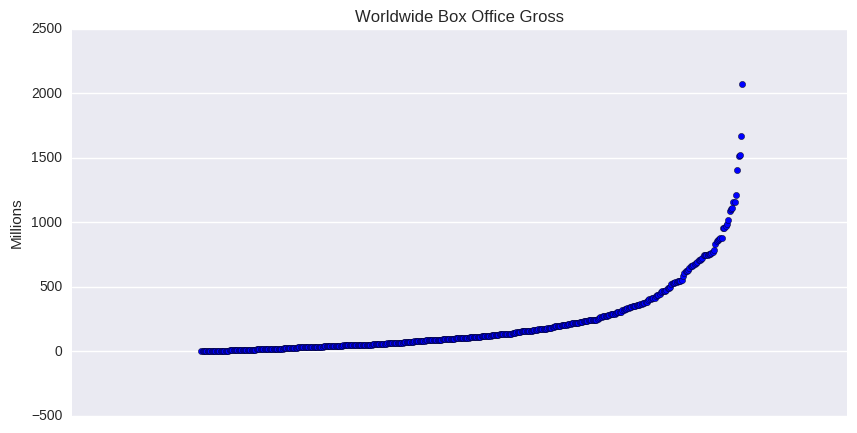

In [11]:
plt.figure(figsize=(10, 5))
ys = df.ww_gross.sort_values()
xs = range(len(ys))
plt.scatter(xs, ys)
plt.xticks([])
plt.ylabel('Millions')
plt.title('Worldwide Box Office Gross');

Plot all of the variable-to-variable relations as scatterplots

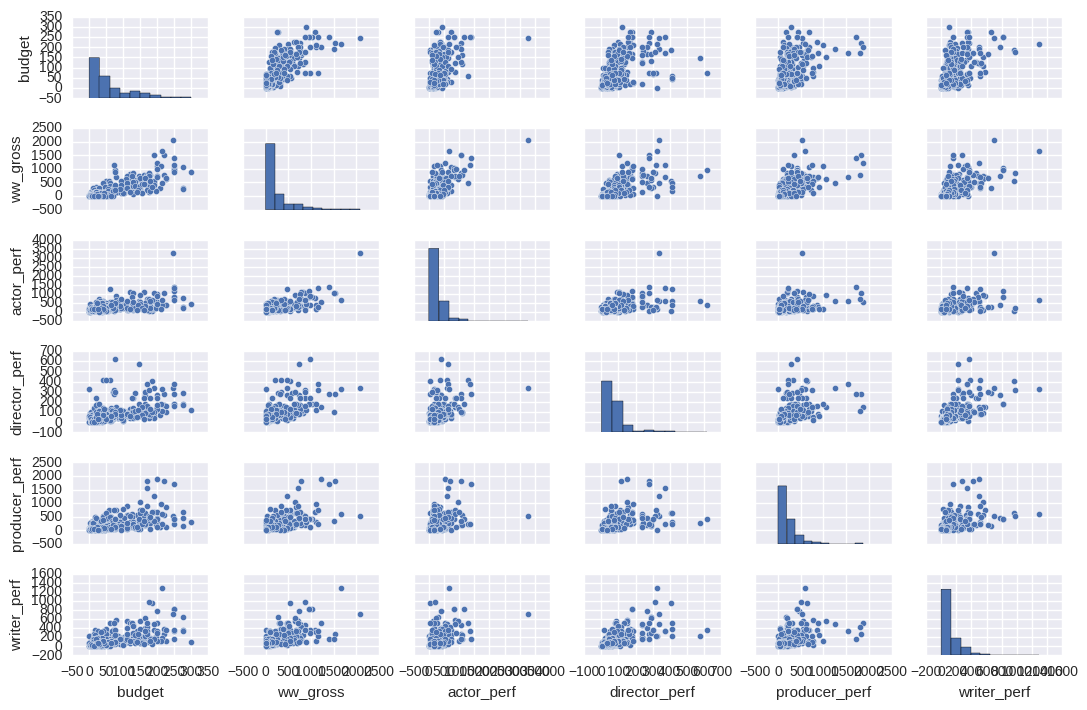

In [12]:
sns.pairplot(df, size = 1.2, aspect=1.5)

Check no variables are perfectly correlated.

In [13]:
df_corr = df.corr()
for col in list(df_corr.columns):
    max_corr = df_corr[col].sort_values(ascending=False)[1]
    print('{0:20s}: {1}'.format(col, max_corr))

budget              : 0.785557863213
ww_gross            : 0.785557863213
actor_perf          : 0.680622012129
director_perf       : 0.654644474871
producer_perf       : 0.62658159346
writer_perf         : 0.670293003799


## Modelling

In [14]:
# create dummies for genre and rating
X_genre = patsy.dmatrix('genre', data=df, return_type='dataframe')
X_rating = patsy.dmatrix('rating', data=df, return_type='dataframe')
X_rating = X_rating.drop('Intercept', axis=1).copy() # drop duplicate intercept

In [15]:
# set up model data
df_model = df.drop(['genre', 'rating'], axis=1).copy()
df_model = df_model.join([X_genre, X_rating])
Y = df_model['ww_gross']
#Y_log = np.log10(Y)
X = df_model.drop(['name', 'ww_gross'], axis=1).copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 2926
Data columns (total 18 columns):
budget                    420 non-null float64
actor_perf                420 non-null float64
director_perf             420 non-null float64
producer_perf             420 non-null float64
writer_perf               420 non-null float64
Intercept                 420 non-null float64
genre[T.animation]        420 non-null float64
genre[T.comedy]           420 non-null float64
genre[T.drama]            420 non-null float64
genre[T.horror]           420 non-null float64
genre[T.musical]          420 non-null float64
genre[T.other]            420 non-null float64
genre[T.romance]          420 non-null float64
genre[T.scifi_fantasy]    420 non-null float64
genre[T.western]          420 non-null float64
rating[T.pg]              420 non-null float64
rating[T.pg13]            420 non-null float64
rating[T.r]               420 non-null float64
dtypes: float64(18)
memory usage: 62.3 KB


In [16]:
# create and fit model
model_A = sm.OLS(Y, X)
fit_A = model_A.fit()
fit_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ww_gross   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     88.73
Date:                Sun, 29 Jan 2017   Prob (F-statistic):          2.35e-124
Time:                        15:40:07   Log-Likelihood:                -2652.4
No. Observations:                 420   AIC:                             5341.
Df Residuals:                     402   BIC:                             5414.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
budget                     1.6757      0.183      9.179      0.000         1.317     2.035
actor_perf                 0.3380      0.032     10.497      0.000         0.275     0.401
director_perf              0.4054      0.127      3.202      0.001         0.157     0.654
producer_perf              0.1946      0.034      5.725      0.000         0.128     0.261
writer_perf                0.2323      0.061      3.800      0.000         0.112     0.352
Intercept                -65.4847    108.650     -0.603      0.547      -279.077   148.108
genre[T.animation]        -9.9142     43.291     -0.229      0.819       -95.019    75.191
genre[T.comedy]          -36.5541     22.725     -1.609      0.108       -81.229     8.120
genre[T.drama]           -21.8707     21.865     -1.000      0.318       -64.854    21.112
genre[T.horror]           10.0120     34.245      0.292      0.770       -57.310    77.334
genre[T.musical]          -9.4369     49.376     -0.191      0.849      -106.505    87.631
genre[T.other]            36.2005     82.871      0.437      0.662      -126.714   199.115
genre[T.romance]          -2.0768     46.779     -0.044      0.965       -94.040    89.886
genre[T.scifi_fantasy]   -15.6248     25.100     -0.622      0.534       -64.969    33.719
genre[T.western]         -80.4345     70.575     -1.140      0.255      -219.177    58.308
rating[T.pg]              29.3242    101.936      0.288      0.774      -171.071   229.719
rating[T.pg13]            -5.2576    105.699     -0.050      0.960      -213.050   202.535
rating[T.r]              -19.3386    106.485     -0.182      0.856      -228.676   189.999
==============================================================================
Omnibus:                      124.594   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.556
Skew:                           1.127   Prob(JB):                    6.95e-161
Kurtosis:                       9.088   Cond. No.                     1.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Explore model performance

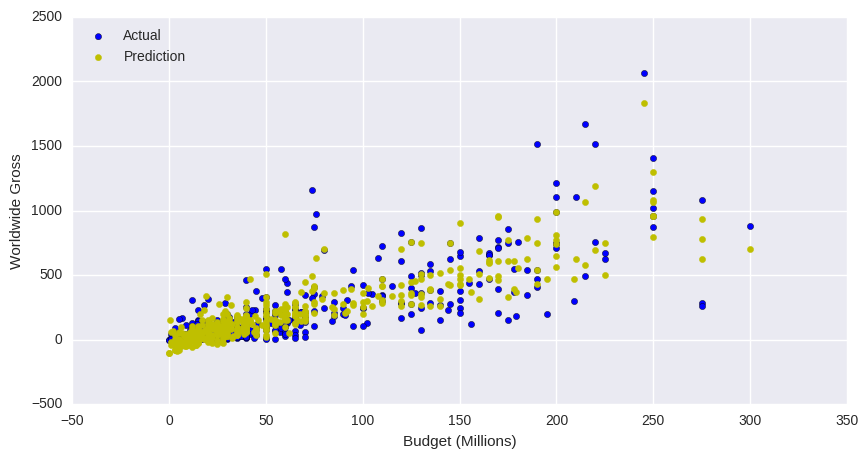

In [17]:
plt.figure(figsize=(10, 5))
Y_pred = fit_A.predict(X)
plt.scatter(df_model.budget, df_model.ww_gross, label='Actual')
plt.scatter(df_model.budget, Y_pred, color='y', label='Prediction')
plt.xlabel('Budget (Millions)')
plt.ylabel('Worldwide Gross')
plt.legend(loc='upper left');

Plot residuals

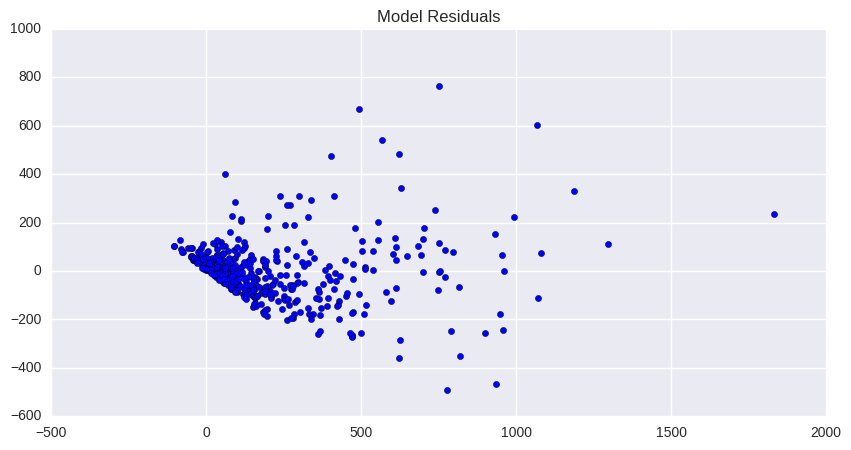

In [18]:
Y_pred = fit_A.predict(X)
xs = range(len(Y_pred))

plt.figure(figsize=(10, 5))
plt.scatter(Y_pred, fit_A.resid)
plt.title('Model Residuals');

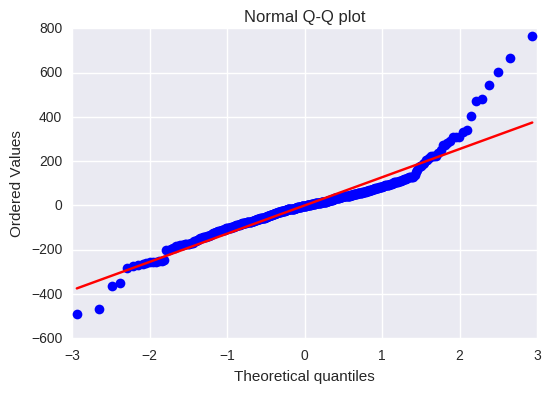

In [19]:
import scipy.stats as stats
stats.probplot(fit_A.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Examine individual features

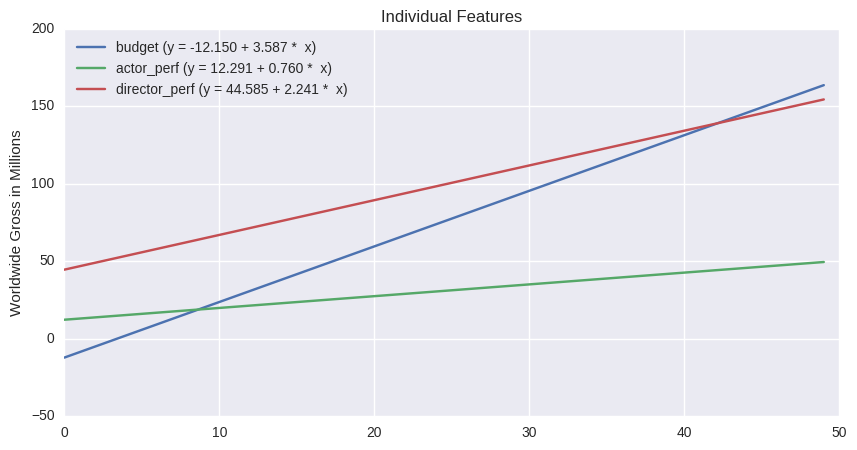

In [20]:
df_ordered = df.sort_values(by='ww_gross').copy()
xs = range(50) 

fig = plt.figure(figsize=(10, 5))
for col in ['budget', 'actor_perf', 'director_perf']:
    df_uni = df_ordered[['ww_gross', col]].copy()
    Y_uni = df_uni['ww_gross']
    X_uni = pd.DataFrame({ 'intercept' : 1.0, col : df_uni[col] })
    model_uni = sm.OLS(Y_uni, X_uni)
    fit_uni = model_uni.fit()
    coeff = fit_uni.params[0]
    intercept = fit_uni.params[1]
    ys = [intercept + (x * coeff) for x in xs]
    plt.plot(xs, ys[:len(xs)], label=col + ' (y = {0:.3f} + {1:.3f} *  x)'.format(intercept, coeff))
    
plt.legend(loc='upper left')
plt.ylabel('Worldwide Gross in Millions')
plt.title('Individual Features');

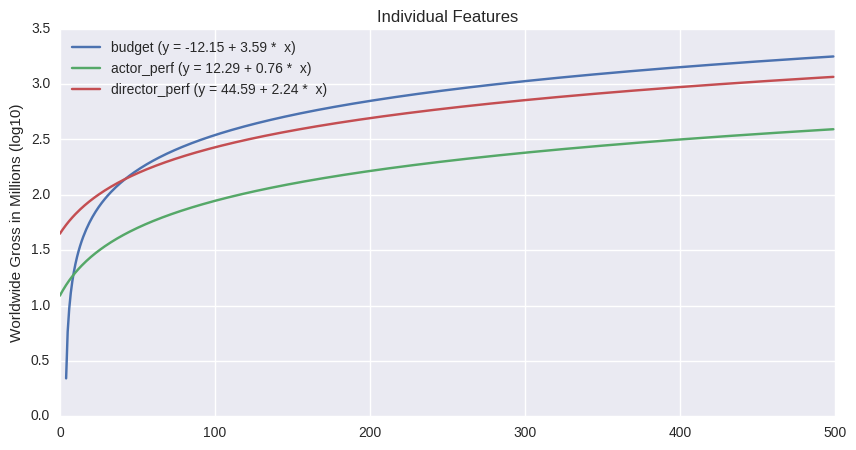

In [21]:
df_ordered = df.sort_values(by='ww_gross').copy()
xs = range(500)

fig = plt.figure(figsize=(10, 5))
for col in ['budget', 'actor_perf', 'director_perf']:
    df_uni = df_ordered[['ww_gross', col]].copy()
    Y_uni = df_uni['ww_gross']
    X_uni = pd.DataFrame({ 'intercept' : 1.0, col : df_uni[col] })
    model_uni = sm.OLS(Y_uni, X_uni)
    fit_uni = model_uni.fit()
    coeff = fit_uni.params[0]
    intercept = fit_uni.params[1]
    ys = [intercept + (x * coeff) for x in xs]
    plt.plot(xs, np.log10(ys[:len(xs)]), label=col + ' (y = {0:.2f} + {1:.2f} *  x)'.format(intercept, coeff))
    
plt.legend(loc='upper left')
plt.ylabel('Worldwide Gross in Millions (log10)')
plt.title('Individual Features');

### Train/test split

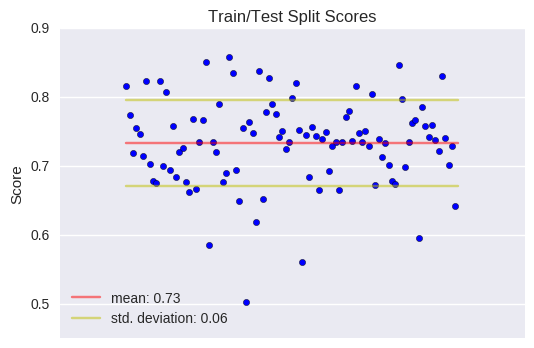

In [22]:
scores = []
for _ in range(100):
    lr = LinearRegression()
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    # Fit the model against the training data
    lr.fit(X_train, y_train)
    # Evaluate the model against the testing data
    scores.append(lr.score(X_test, y_test))

mean = np.mean(scores)
std = np.std(scores)

plt.scatter(range(len(scores)), scores)
plt.plot([0, len(scores)], [mean, mean], color='r', label='mean: {0:.2f}'.format(mean), alpha=0.5)
plt.plot([0, len(scores)], [mean+std, mean+std], color='y', label='std. deviation: {0:.2f}'.format(std), alpha=0.5)
plt.plot([0, len(scores)], [mean-std, mean-std], color='y', alpha=0.5)
plt.xticks([])
plt.title('Train/Test Split Scores')
plt.ylabel('Score');
plt.legend(loc='lower left');

### Normalization

In [23]:
from sklearn import preprocessing
X_scaled = preprocessing.normalize(X, axis=0, norm='max')
Y_scaled = Y
model_B = sm.OLS(Y_scaled, X_scaled)
fit_B = model_B.fit()
fit_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ww_gross   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     88.73
Date:                Sun, 29 Jan 2017   Prob (F-statistic):          2.35e-124
Time:                        15:40:10   Log-Likelihood:                -2652.4
No. Observations:                 420   AIC:                             5341.
Df Residuals:                     402   BIC:                             5414.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           502.7066     54.769      9.179      0.000       395.037   610.376
x2          1105.7675    105.346     10.497      0.000       898.669  1312.866
x3           250.9311     78.359      3.202      0.001        96.887   404.975
x4           366.0678     63.939      5.725      0.000       240.372   491.764
x5           301.0249     79.219      3.800      0.000       145.289   456.760
const        -65.4847    108.650     -0.603      0.547      -279.077   148.108
x6            -9.9142     43.291     -0.229      0.819       -95.019    75.191
x7           -36.5541     22.725     -1.609      0.108       -81.229     8.120
x8           -21.8707     21.865     -1.000      0.318       -64.854    21.112
x9            10.0120     34.245      0.292      0.770       -57.310    77.334
x10           -9.4369     49.376     -0.191      0.849      -106.505    87.631
x11           36.2005     82.871      0.437      0.662      -126.714   199.115
x12           -2.0768     46.779     -0.044      0.965       -94.040    89.886
x13          -15.6248     25.100     -0.622      0.534       -64.969    33.719
x14          -80.4345     70.575     -1.140      0.255      -219.177    58.308
x15           29.3242    101.936      0.288      0.774      -171.071   229.719
x16           -5.2576    105.699     -0.050      0.960      -213.050   202.535
x17          -19.3386    106.485     -0.182      0.856      -228.676   189.999
==============================================================================
Omnibus:                      124.594   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.556
Skew:                           1.127   Prob(JB):                    6.95e-161
Kurtosis:                       9.088   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""